# Hilbert transform and phase estimates

In [150]:
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import hilbert

## Demo signal

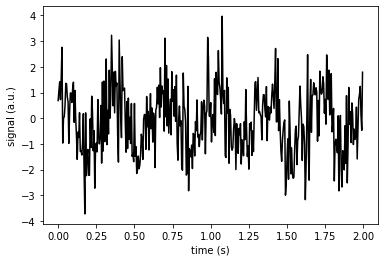

In [161]:
freq, phase0 = 3, 1.
tstop, dt = 2, 5e-3
noise_amp = 1.
t = np.arange(int(tstop/dt))*dt
signal = np.sin(2*np.pi*t*freq+phase0) + noise_amp * np.random.randn(len(t))# sin + noise
plt.plot(t, signal, 'k-')
plt.xlabel('time (s)')
plt.ylabel('signal (a.u.)');

## Hilbert transform

In [162]:
# Hilbert Tranform from scipy
Hilbert = hilbert(signal) # Hilbert transform

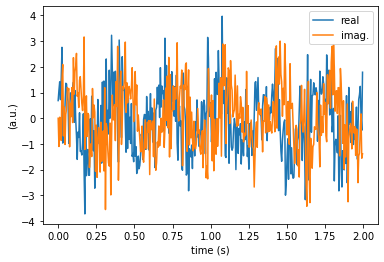

In [163]:
# plotting real and imaginary part
plt.plot(t, np.real(Hilbert), label='real')
plt.plot(t, np.imag(Hilbert), label='imag.')
plt.xlabel('time (s)')
plt.ylabel('(a.u.)')
plt.legend();

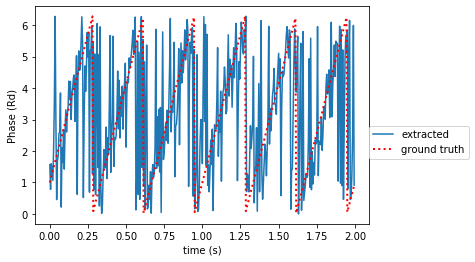

In [164]:
# extracting phase angle
extracted_phase = np.angle(-1j*signal+np.imag(Hilbert))+np.pi
plt.plot(t, extracted_phase, label='extracted') # from 0 to 2*Pi
plt.plot(t, (2*np.pi*freq*t+phase0)%(2*np.pi), 'r:', lw=2, label='ground truth')
plt.xlabel('time (s)')
plt.ylabel('Phase (Rd)');
plt.legend(loc=(1.,.3))

## Using cumulative phase to smooth the variations

Text(0, 0.5, 'cumsum-phase (Rd*second)')

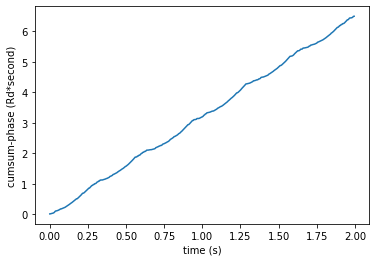

In [165]:
# cumsum
plt.plot(t, np.cumsum(extracted_phase)*dt, label='data')
plt.xlabel('time (s)')
plt.ylabel('cumsum-phase (Rd*second)')



- If the phase raises linearly over time with resets, one can calculate the cumulative phase over time:
$$
CP(t) = \frac{\lfloor t f \rfloor}{f} / f + \pi \cdot f * (t- \frac{\lfloor t f \rfloor}{f})^2 
$$
where $\lfloor \, \rfloor$ is the floor function.


- The linear approximation to the cumulated phase is simply:
$$
CP(t) = \pi*t
$$

In [166]:
# implementing the above formula
def theoretical_cumsum(t, freq=1, phase0=0):
    n = np.floor(t*freq+phase0/2/np.pi)
    Dt = t-n/freq+phase0/2/np.pi/freq
    return n*np.pi/freq+np.pi*Dt**2*freq

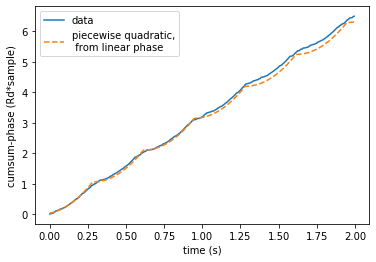

In [167]:
plt.plot(t, np.cumsum(extracted_phase)*dt, label='data')
plt.plot(t, phase0*dt+theoretical_cumsum(t, freq, phase0), '--', label='piecewise quadratic,\n from linear phase')
#plt.plot(t, np.pi*t, ':', label='linear approx')
plt.xlabel('time (s)')
plt.ylabel('cumsum-phase (Rd*sample)')
plt.legend()

# Inverting the above relation to get a phase estimate

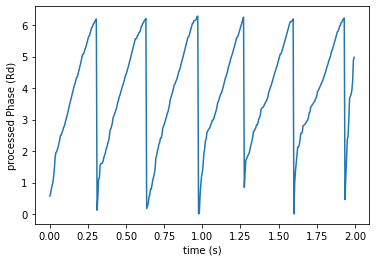

In [171]:
# we interpolate the theoretical curve (the inverse, cumsum as a function of phase)
from scipy.interpolate import interp1d
cumsum_to_phase_func = interp1d(phase0*dt+theoretical_cumsum(t, freq, phase0),
                                2*np.pi*t*freq+phase0, kind='linear', fill_value="extrapolate")
# and apply it to the data
plt.plot(t, cumsum_to_phase_func(np.cumsum(extracted_phase)*dt) %(2*np.pi))
plt.xlabel('time (s)')
plt.ylabel('processed Phase (Rd)');

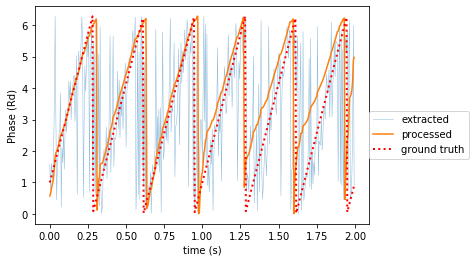

In [169]:
# extracting phase angle
extracted_phase = np.angle(-1j*signal+np.imag(Hilbert))+np.pi
plt.plot(t, extracted_phase, label='extracted', lw=0.5, alpha=.5) # from 0 to 2*Pi
plt.plot(t, cumsum_to_phase_func(np.cumsum(extracted_phase)*dt) %(2*np.pi), label='processed')
plt.plot(t, (2*np.pi*freq*t+phase0)%(2*np.pi), 'r:', lw=2, label='ground truth')
plt.xlabel('time (s)')
plt.ylabel('Phase (Rd)');
plt.legend(loc=(1.,.3))

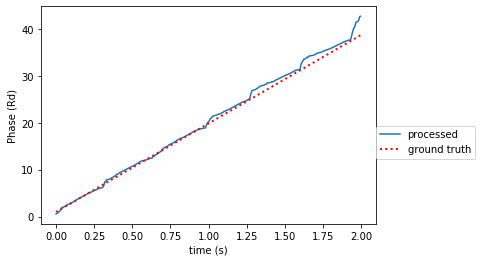

In [170]:
# phase not clipped to [0,2*pi]
plt.plot(t, cumsum_to_phase_func(np.cumsum(extracted_phase)*dt), label='processed')
plt.plot(t, (2*np.pi*freq*t+phase0), 'r:', lw=2, label='ground truth')
plt.xlabel('time (s)')
plt.ylabel('Phase (Rd)');
plt.legend(loc=(1.,.3))

-> One can use the interpolation to predict the phase at any given time